# Two Fires, One Target, Constant Wind

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import multivariate_normal
from scipy.integrate import solve_bvp
import matplotlib.image as mpimg
from scipy import ndimage
from PIL import Image

In [25]:
fire_cost = 50_000 # Cost of fire

def fire(t, x, y, x0, y0, w1, w2, u_x, u_y, sigma2_0, k, c):
    """
    Fire dynamics model.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    w1 (float): Wind speed in x-direction
    w2 (float): Wind speed in y-direction
    u_x (float): Wind direction in x (unit vector)
    u_y (float): Wind direction in y (unit vector)
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    float: Fire intensity at time t
    """
    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements for each t
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute determinant and inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")

    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    # Compute exponent
    exponent = -0.5 * (inv_11 * dx**2 + 2 * inv_12 * dx * dy + inv_22 * dy**2)
    normalization = 1.0 / (2 * np.pi * np.sqrt(det))
    return fire_cost * normalization * np.exp(exponent)

def grad_fire(t, x, y, x0, y0, w1, w2, u_x, u_y, sigma2_0, k, c):
    """
    Gradient of fire intensity.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    w1 (float): Wind speed in x-direction
    w2 (float): Wind speed in y-direction
    u_x (float): Wind direction in x (unit vector)
    u_y (float): Wind direction in y (unit vector)
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    np.ndarray: Gradient of fire intensity
    """
    f = fire(t, x, y, x0, y0, w1, w2, u_x, u_y, sigma2_0, k, c)
    
    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")
    
    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    grad_x = -f * (inv_11 * dx + inv_12 * dy)
    grad_y = -f * (inv_12 * dx + inv_22 * dy)
    
    return grad_x, grad_y

## Suitable Fires and Target

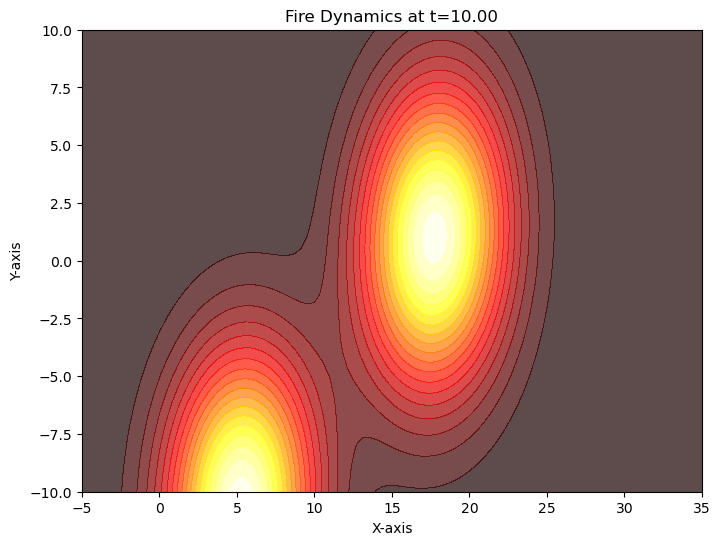

In [26]:
s0 = np.array([0, 0, 0, 0])  # Initial state
target = np.array([30, 0])  # Target (x, y) coordinates
w1, w2 = -0.1, -1.0  # Wind points mostly down
u_norm = np.sqrt(w1**2 + w2**2)
u_x, u_y = w1 / u_norm, w2 / u_norm  # Unit vector in wind direction
sigma_0 = 0.1
k = 2
c = 1

fire1_init = np.array([6.25, -0.5])  # Initial fire position
fire2_init = np.array([18.75, 11.0])  # Initial fire position

x, y = np.linspace(-5, 35, 100), np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-5, 35)
ax.set_ylim(-10, 10)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Fire Dynamics Simulation')

contour = None

def update(t):
    global contour
    if contour is not None:
        for coll in contour.collections:
            coll.remove()
    
    mean1 = [fire1_init[0] + w1 * t, fire1_init[1] + w2 * t]
    mean2 = [fire2_init[0] + w1 * t, fire2_init[1] + w2 * t]
    sigma_parallel = sigma_0 + k * t
    sigma_perp = sigma_0 + c * t

    Sigma = np.array([
        [u_x**2 * sigma_parallel + u_y**2 * sigma_perp, 
         u_x * u_y * (sigma_parallel - sigma_perp)],
        [u_x * u_y * (sigma_parallel - sigma_perp), 
         u_y**2 * sigma_parallel + u_x**2 * sigma_perp]
    ])

    Z1 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean1, cov=Sigma)
    Z2 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean2, cov=Sigma)

    Z = Z1 + Z2

    contour = ax.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.7)
    ax.set_title(f'Fire Dynamics at t={t:.2f}')
    return contour.collections

ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 10, 100), blit=True)

ani.save('animations/fire3.mp4', writer='ffmpeg', fps=20)

## Optimal Control

Given that the target is at $(30, 0)$ and video of the fire behavior, we hope that the agent finds an optimal path similar to a sine curve.

In [27]:
control_penalty = 1
time_penalty = 100

def fire_ode(t, z, p):
    x, y, vx, vy, p1, p2, p3, p4 = z
    tf = np.clip(p[0], 0, None)
    f1_x, f1_y = grad_fire(tf * t, x, y, fire1_init[0], fire1_init[1], w1, w2, u_x, u_y, sigma_0, k, c)
    f2_x, f2_y = grad_fire(tf * t, x, y, fire2_init[0], fire2_init[1], w1, w2, u_x, u_y, sigma_0, k, c)
    return tf * np.array([
        vx,
        vy,
        0.5 * p3 / control_penalty,
        0.5 * p4 / control_penalty,
        f1_x + f2_x,
        f1_y + f2_y,
        -p1,
        -p2
    ])

def bc(ya, yb, p):
    x, y, vx, vy, p1, p2, p3, p4 = yb
    u1, u2 = 0.5 * p3 / control_penalty, 0.5 * p4 / control_penalty
    tf = np.clip(p[0], 0, None)
    fire1 = fire(tf, x, y, fire1_init[0], fire1_init[1], w1, w2, u_x, u_y, sigma_0, k, c)
    fire2 = fire(tf, x, y, fire2_init[0], fire2_init[1], w1, w2, u_x, u_y, sigma_0, k, c)
    H = p1*vx + p2*vy + p3*u1 + p4*u2 - (time_penalty + fire1 + fire2 + control_penalty * (u1**2 + u2**2))
    return np.array([
        ya[0] - s0[0],
        ya[1] - s0[1],
        ya[2] - s0[2],
        ya[3] - s0[3],
        yb[0] - target[0],
        yb[1] - target[1],
        yb[2],
        yb[3],
        H
    ]) 

t_steps = 100
t = np.linspace(0, 1, t_steps)
z0 = np.zeros((8, t_steps))
z0[0, :] = np.linspace(s0[0], target[0], t_steps)
z0[1, :] = np.linspace(s0[1], target[1], t_steps)
p0 = np.array([1.0])
v_guess = (target - s0[:2]) / p0[0]
z0[2, :] = v_guess[0]
z0[3, :] = v_guess[1]

sol = solve_bvp(fire_ode, bc, t, z0, p0, tol=1e-3, max_nodes=50_000)

if not sol.success:
    print("BVP solver failed:", sol.message)

In [28]:
len(sol.x)

299

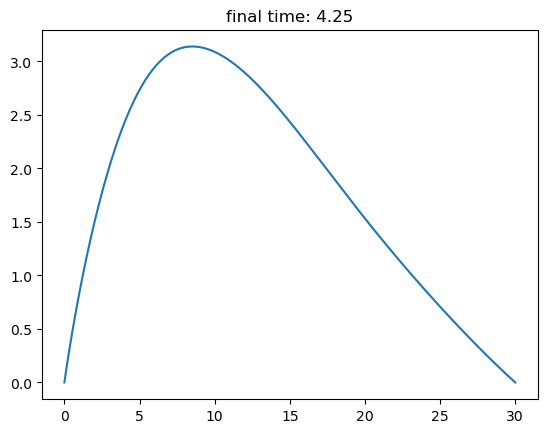

In [29]:
plt.plot(sol.y[0], sol.y[1], label='Optimal Path')
plt.title(f'final time: {sol.p[0]:.2f}')
plt.show()

/var/folders/lc/6n3k9ht52fxdnv5mqyw8tngh0000gn/T/ipykernel_45065/2825790380.py:55: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  current_pos.set_data([x_traj[mask][-1], y_traj[mask][-1]])


KeyboardInterrupt: 

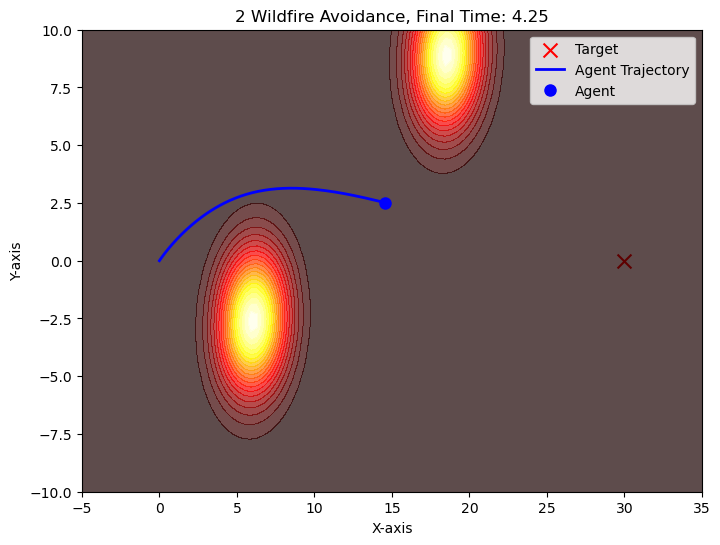

In [40]:
tf = sol.p[0]
x_traj, y_traj = sol.y[0], sol.y[1]
t_eval = np.linspace(0, tf, len(x_traj))  # Full resolution time vector

# Create a lower-resolution time vector just for the animation
n_frames = 200  # Adjust as needed
t_anim_vals = np.linspace(0, tf, n_frames)

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-5, 35)
ax.set_ylim(-10, 10)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2 Wildfire Avoidance, Final Time: {:.2f}'.format(tf))

# Plot target
ax.scatter(target[0], target[1], marker='x', color='red', label='Target', s=100)

contour = None
traj_line, = ax.plot([], [], 'b-', lw=2, label='Agent Trajectory')
current_pos, = ax.plot([], [], 'bo', label='Agent', markersize=8)
ax.legend()

def update(t_anim):
    global contour
    if contour is not None:
        for coll in contour.collections:
            coll.remove()
    
    # Fire center positions at this frame
    mean1 = [fire1_init[0] + w1 * t_anim, fire1_init[1] + w2 * t_anim]
    mean2 = [fire2_init[0] + w1 * t_anim, fire2_init[1] + w2 * t_anim]
    sigma_parallel = sigma_0 + k * t_anim
    sigma_perp = sigma_0 + c * t_anim

    Sigma = np.array([
        [u_x**2 * sigma_parallel + u_y**2 * sigma_perp, 
         u_x * u_y * (sigma_parallel - sigma_perp)],
        [u_x * u_y * (sigma_parallel - sigma_perp), 
         u_y**2 * sigma_parallel + u_x**2 * sigma_perp]
    ])

    # Compute the fire intensity heatmap
    Z1 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean1, cov=Sigma)
    Z2 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean2, cov=Sigma)
    Z = Z1 + Z2

    contour = ax.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.7)

    # Update trajectory up to current time
    mask = t_eval <= t_anim
    traj_line.set_data(x_traj[mask], y_traj[mask])
    if mask.any():
        current_pos.set_data([x_traj[mask][-1], y_traj[mask][-1]])

    return []

# Animate using downsampled frames
ani = animation.FuncAnimation(
    fig, update, frames=t_anim_vals, blit=False, interval=50, repeat=True
)

# Save animation
ani.save('animations/fire2_avoid_constw.mp4', writer='ffmpeg', fps=40)


## Overlay the drone image

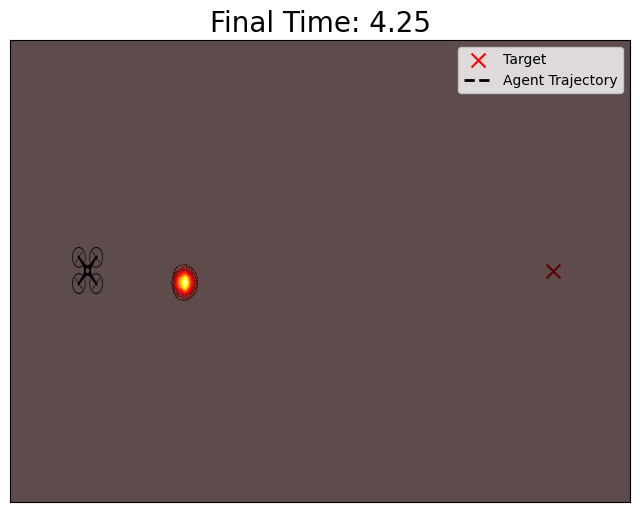

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-5, 35)
ax.set_ylim(-10, 10)
ax.set_title('Final Time: {:.2f}'.format(tf), fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

# Plot target
ax.scatter(target[0], target[1], marker='x', color='red', label='Target', s=100)

contour = None
traj_line, = ax.plot([], [], 'k--', lw=2, label='Agent Trajectory')  # White dashed line
ax.legend(facecolor='white')

# Load drone and fire emoji images
drone_img = mpimg.imread("drone2.png")
drone_size = 1.0
drone = ax.imshow(drone_img, extent=[-100, -99, -100, -99], zorder=3, aspect='auto')

def update(t_anim):
    global contour

    if contour is not None:
        for coll in contour.collections:
            coll.remove()
    
    mean1 = [fire1_init[0] + w1 * t_anim, fire1_init[1] + w2 * t_anim]
    mean2 = [fire2_init[0] + w1 * t_anim, fire2_init[1] + w2 * t_anim]
    sigma_parallel = sigma_0 + k * t_anim
    sigma_perp = sigma_0 + c * t_anim

    Sigma = np.array([
        [u_x**2 * sigma_parallel + u_y**2 * sigma_perp, 
         u_x * u_y * (sigma_parallel - sigma_perp)],
        [u_x * u_y * (sigma_parallel - sigma_perp), 
         u_y**2 * sigma_parallel + u_x**2 * sigma_perp]
    ])

    Z1 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean1, cov=Sigma)
    Z2 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean2, cov=Sigma)
    Z = Z1 + Z2

    contour = ax.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.7)

    # Update trajectory
    mask = t_eval <= t_anim
    traj_line.set_data(x_traj[mask], y_traj[mask])

    if mask.any():
        x_curr, y_curr = x_traj[mask][-1], y_traj[mask][-1]
        drone_extent = [
            x_curr - drone_size, x_curr + drone_size,
            y_curr - drone_size, y_curr + drone_size
        ]

        drone.set_extent(drone_extent)

    return []


ani = animation.FuncAnimation(
    fig, update, frames=t_anim_vals, blit=False, interval=50, repeat=True
)
ani.save('animations/fire2_drone_constw.mp4', writer='ffmpeg', fps=40)


In [50]:
t_start = t_anim_vals[50]
t_mid = t_anim_vals[len(t_anim_vals) // 2 + 20]
t_end = t_anim_vals[-1]

for label, t_snapshot in zip(["early", "mid", "late"], [t_start, t_mid, t_end]):
    update(t_snapshot)
    fig.savefig(f"fire2_drone_const2_{label}.png", dpi=800, bbox_inches='tight')
